In questo Jupyter Notebook verrà svolta un analisi della serie storica relativa al fatturato degli ultimi 10 anni

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss





In [149]:
ecommerce= pd.read_csv('C:/Users/glori/OneDrive/Desktop/ecommerce.csv/sportit.csv', sep=",", encoding='latin-1')

Aggiungo la colonna fatturato

In [150]:
for i in range(len(ecommerce)):
    ecommerce.loc[i,"Fatturato"]=ecommerce.loc[i,'qta']*ecommerce.loc[i,'prezzo']


In [151]:
ecommerce.head()

,Unnamed: 0,id,marchio,descrizione,settore,qta,prezzo,data,Anno,Mese,Giorno,Giorno_Settimana,Ora,Fatturato
0,0,37586,Protest,Pantalone imbottito,Snowboard,1,408.870,2015-04-24 12:32:12.002000,2015,4,24,Friday,12:32:12,408.870
1,1,43076,Nike,Neutre,Running,1,582.330,2015-06-22 23:43:55.520000,2015,6,22,Monday,23:43:55,582.330
2,2,36396,Nike,Pallone,Calcio,1,103.250,2015-04-11 02:10:58.754000,2015,4,11,Saturday,02:10:58,103.250
3,3,39259,Skechers,Scarpa,Fitness,1,329.987,2015-05-14 20:30:03.789000,2015,5,14,Thursday,20:30:03,329.987
4,4,41154,Adidas,Pantaloncino ufficiale,Calcio,1,45.430,2015-06-05 12:39:46.346000,2015,6,5,Friday,12:39:46,45.430


Creo un dataset con il fatturato mensile e la colonna 'Anno_Mese'

In [162]:
new_data=pd.DataFrame()


In [163]:
new_data = ecommerce.groupby(['Anno', 'Mese'])['Fatturato'].sum()

In [164]:
new_data = new_data.to_frame()
new_data = new_data.reset_index()

In [165]:
new_data['Anno_Mese'] = new_data['Anno'].astype(str) + '-' + new_data['Mese'].astype(str).str.zfill(2)


Eseguo un primo plot della serie storica

In [167]:
drops = ['Anno','Mese']
new_data.drop(drops, axis=1, inplace=True)


Text(0, 0.5, 'Fatturato')

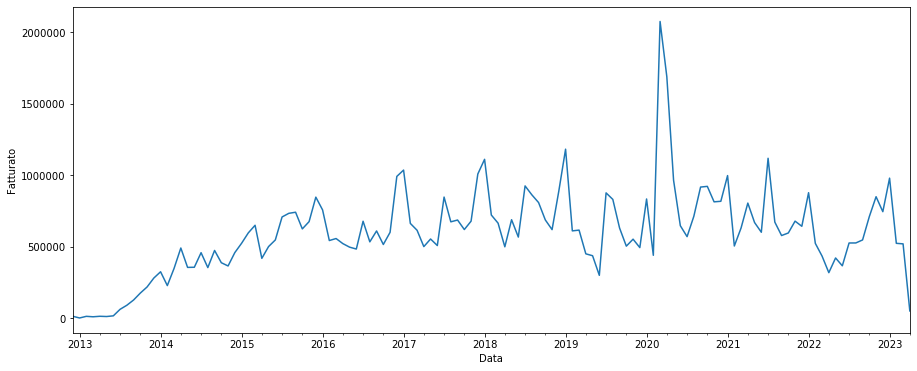

In [168]:
new_data = new_data.set_index('Anno_Mese')
new_data.index = pd.to_datetime(new_data.index)
y = new_data['Fatturato']
# Creo il grafico
y.plot(figsize=(15, 6))
plt.xlabel('Data')
plt.ylabel('Fatturato')

Eseguo una decomposizione della serie storica per isolare il trend e la stagionalità

In [169]:
result = seasonal_decompose(new_data, model='additive')

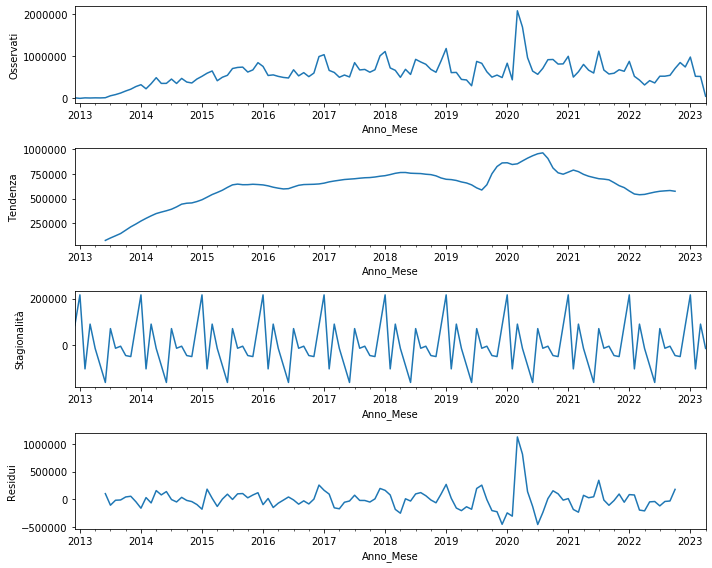

In [170]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
result.observed.plot(ax=ax1)
ax1.set_ylabel('Osservati')
result.trend.plot(ax=ax2)
ax2.set_ylabel('Tendenza')
result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Stagionalità')
result.resid.plot(ax=ax4)
ax4.set_ylabel('Residui')
plt.tight_layout()
plt.show()

I fattori critici che osserviamo sono: la presenza di stagionaltà annuale, un picco anomalo in corrispondenza dell'anno del covid e un trend leggermente in crescita

Analizzo il grafico dell'autocorrelazione

C:\Users\glori\AppData\Local\Temp\ipykernel_25552\3949944919.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(acf)


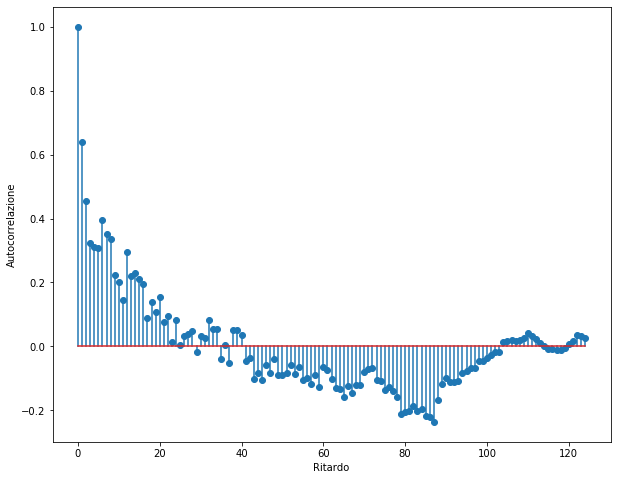

In [176]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 8))

# Calcola l'autocorrelazione dei dati con ritardi diversi
acf = sm.tsa.acf(new_data['Fatturato'], nlags=len(new_data)-1)

# Visualizza il grafico dell'autocorrelazione
plt.stem(acf)
plt.xlabel('Ritardo')
plt.ylabel('Autocorrelazione')
plt.show()

Prima di addestarre un qualsiasi modello, svolgo il test di Dickey-Fuller per indagare la stazionarietà in media 

In [171]:
result = adfuller(new_data['Fatturato'])
p_value = result[1]

if p_value < 0.05:
    print("La serie è stazionaria in media")
else:
    print("La serie non è stazionaria in media")

La serie non è stazionaria


La serie non è stazionaria in media, verifichiamo se è stazionaria in varianza 

In [173]:
# Esecuzione del test KPSS
result = kpss(new_data['Fatturato'])
p_value_kpss = result[1]
if p_value_kpss < 0.05:
    print("La serie è stazionaria in varianza")
else:
    print("La serie non è stazionaria in varianza")


Test statistic: 0.9710160674733804
P-value: 0.01
Lags used: 5
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Attuo una trasformazione logaritmica per rendere la serie stazionarie e per "modellare" il caso anomalo 

In [183]:
serie_trasformata = np.log(new_data['Fatturato'])

In [175]:
result = adfuller(serie_trasformata)
p_value = result[1]

if p_value < 0.05:
    print("La serie è stazionaria")
else:
    print("La serie non è stazionaria")

La serie è stazionaria


Ora che la serie è stazionaria svolgo l'analisi della correlazione e correlazione parziale

C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


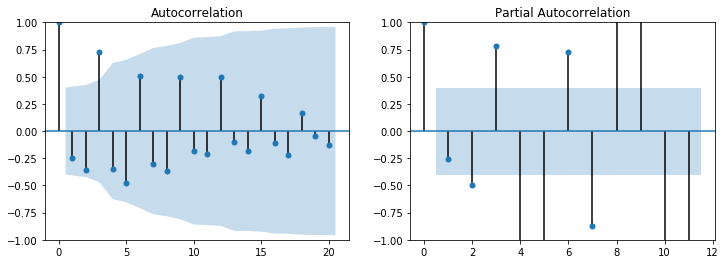

In [180]:
# Calcola l'ACF e il PACF
acf = sm.tsa.stattools.acf(new_data['Fatturato'], nlags=20)
pacf = sm.tsa.stattools.pacf(new_data['Fatturato'], nlags=20)

# Crea i grafici dell'ACF e del PACF
plt.figure(figsize=(12, 4))
plt.subplot(121)
sm.graphics.tsa.plot_acf(data, lags=20, ax=plt.gca())
plt.subplot(122)
sm.graphics.tsa.plot_pacf(data, lags=11, ax=plt.gca())
plt.show()

Il grafico della PACF sembra avere picchi con la stessa frequenza, ciò indica la presenza di stagionalità

Vediamo il plot della serie storica con la trasformazione logaritmica

Text(0, 0.5, 'Fatturato')

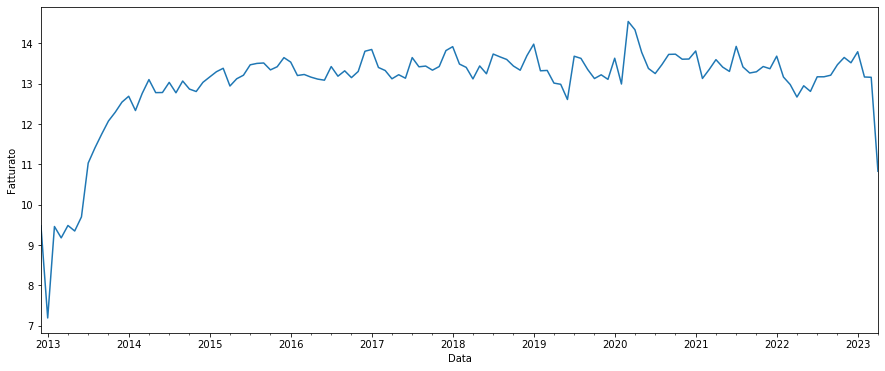

In [184]:
y = serie_trasformata
# Creo il grafico
y.plot(figsize=(15, 6))
plt.xlabel('Data')
plt.ylabel('Fatturato')

Sembra essere molto più omogenea

Implementiamo ora alcuni modelli per serie storiche: AR, MA, ARMA, ARIMA, SARIMA per poi scegliere in base a dei criteri quale è il più indicato per la nostra serie 

In [189]:
from statsmodels.tsa.ar_model import AutoReg
n=12
# Creazione del modello AR
model = AutoReg(serie_trasformata, lags=1)

# Adattamento del modello ai dati
model_fit = model.fit()

# Generazione delle previsioni
predictions = model_fit.predict(start=len(serie_trasformata), end=len(serie_trasformata)+n)
predictions

C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


2023-05-01    11.128202
2023-06-01    11.388357
2023-07-01    11.614329
2023-08-01    11.810609
2023-09-01    11.981100
2023-10-01    12.129189
2023-11-01    12.257821
2023-12-01    12.369551
2024-01-01    12.466600
2024-02-01    12.550898
2024-03-01    12.624120
2024-04-01    12.687720
2024-05-01    12.742964
Freq: MS, dtype: float64

In [192]:
from statsmodels.tsa.arima.model import ARMA
n=12
data=serie_trasformata
# Creazione del modello MA
model = ARMA(data, order=(0, 1))

# Adattamento del modello ai dati
model_fit = model.fit()

# Generazione delle previsioni
predictions = model_fit.predict(start=len(data), end=len(data)+n)

ImportError: cannot import name 'ARMA' from 'statsmodels.tsa.arima.model' (C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\arima\model.py)

In [193]:
from statsmodels.tsa.arima.model import ARMA
data=serie_trasformata

# Creazione del modello ARMA
model = ARMA(data, order=(1, 1))

# Adattamento del modello ai dati
model_fit = model.fit()

# Generazione delle previsioni
predictions = model_fit.predict(start=len(data), end=len(data)+n)

ImportError: cannot import name 'ARMA' from 'statsmodels.tsa.arima.model' (C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\arima\model.py)

In [195]:
from statsmodels.tsa.arima.model import ARIMA
data=serie_trasformata

# Creazione del modello ARIMA
model = ARIMA(data, order=(1, 1, 1))

# Adattamento del modello ai dati
model_fit = model.fit()

# Generazione delle previsioni
predictions = model_fit.predict(start=len(data), end=len(data)+n)
predictions

C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


2023-05-01    11.734895
2023-06-01    11.009637
2023-07-01    11.590082
2023-08-01    11.125535
2023-09-01    11.497325
2023-10-01    11.199771
2023-11-01    11.437912
2023-12-01    11.247321
2024-01-01    11.399856
2024-02-01    11.277778
2024-03-01    11.375481
2024-04-01    11.297286
2024-05-01    11.359867
Freq: MS, Name: predicted_mean, dtype: float64

In [196]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Creazione del modello SARIMA
model = SARIMAX(data, order=(1, 1, 1), seasonal_order=(1, 1, 1, m))

# Adattamento del modello ai dati
model_fit = model.fit()

# Generazione delle previsioni
predictions = model_fit.predict(start=len(data), end=len(data)+n)

NameError: name 'm' is not defined